# Load the required package


In [2]:
import random
import scipy.misc
import csv
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.contrib.learn as skflow

from numpy import float32
from numpy import uint8
from numpy import int64
from PIL import Image
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Read mammogram test and training data

In [5]:
def readTrainTest():
    num_images = 201
    img_length = 50
    #read image pixel vals in
    fileName = "./data/raw_data/UPNG/mdb"
    train_mgrams = []
    test_mgrams = []

    for i in range(1,num_images):
        if i < 100:
            if i < 10:
                fname = fileName + "00" + str(i) + ".png"
            else:
                fname = fileName + "0" + str(i) + ".png"
        else:
            name = fileName + str(i) + ".png"

        im = Image.open(fname).load() 

        center = random.randrange(482,542)

        pixels = [im[k,j] for k in range(center-img_length, center + img_length) 
                  for j in range(center - img_length, center +img_length)]

        if i < num_images - 100:
            train_mgrams.append(pixels)
        else:
            test_mgrams.append(pixels)

    training_data = np.ndarray(shape=(num_images - 1 - 50,100*100), buffer=np.array(train_mgrams), dtype=float32)
    testing_data = np.ndarray(shape=(100,100*100), buffer=np.array(test_mgrams), dtype=float32)

    #read label data and convert as one hot conversion
    f=open("./data/labels.csv")
    labels = []
    for row in csv.reader(f, delimiter=' '):
        #N, B, M
        if row[3] == "N":
            #labels.append([1,0,0])
            labels.append(0)
        elif row[3] == "B":
            #labels.append([0,1,0])
            labels.append(1)
        else:
            #labels.append([0,0,1])
            labels.append(2)

    del labels[num_images:]
    training_labels = np.ndarray(shape=(num_images - 1 - 100,), buffer=np.array(labels[:num_images - 50]), dtype=int64)
    testing_labels = np.ndarray(shape=(100,), buffer=np.array(labels[num_images - 100:]), dtype=int64)
    print('No of training images ',len(train_mgrams))
    print('No of training labels ',len(training_labels))
    print('Training dataset pixel size',len(train_mgrams[0]))

    print('No of test set images ',len(test_mgrams))
    print('No of test set labels ',len(testing_labels))
    print('Test dataset pixel size',len(test_mgrams[0]))
    return  (test_mgrams,training_data, testing_data, training_labels, testing_labels)

In [6]:
# Load mammogram data
test_number = 2#Set is as default one

print("Loading in Mammogram data...")
train_mgrams,training_data, testing_data, training_labels, testing_labels=readTrainTest()
print("Mammogram data loaded.\n")

### GLOBAL CONSTANTS

POOLING_X_DIM = 2
POOLING_Y_DIM = 2
IMAGE_X_DIM = 48
IMAGE_Y_DIM = 48
FEATURES_LAYER_1 = 32
FEATURES_LAYER_2 = 64
FEATURES_LAYER_3 = 128
KERNEL_LAYER_1 = 5
KERNEL_LAYER_2 = 5
KERNEL_LAYER_3 = 5
NUM_LAYERS = 2
NUM_FOLDS = 8
if test_number == 2:
    NUM_CLASSES = 3
else:
    NUM_CLASSES = 2
NUM_STEPS = 10000
LEARN_RATE = .003

Loading in Mammogram data...
No of training images  100
No of training labels  100
Training dataset pixel size 10000
No of test set images  100
No of test set labels  100
Test dataset pixel size 10000
Mammogram data loaded.



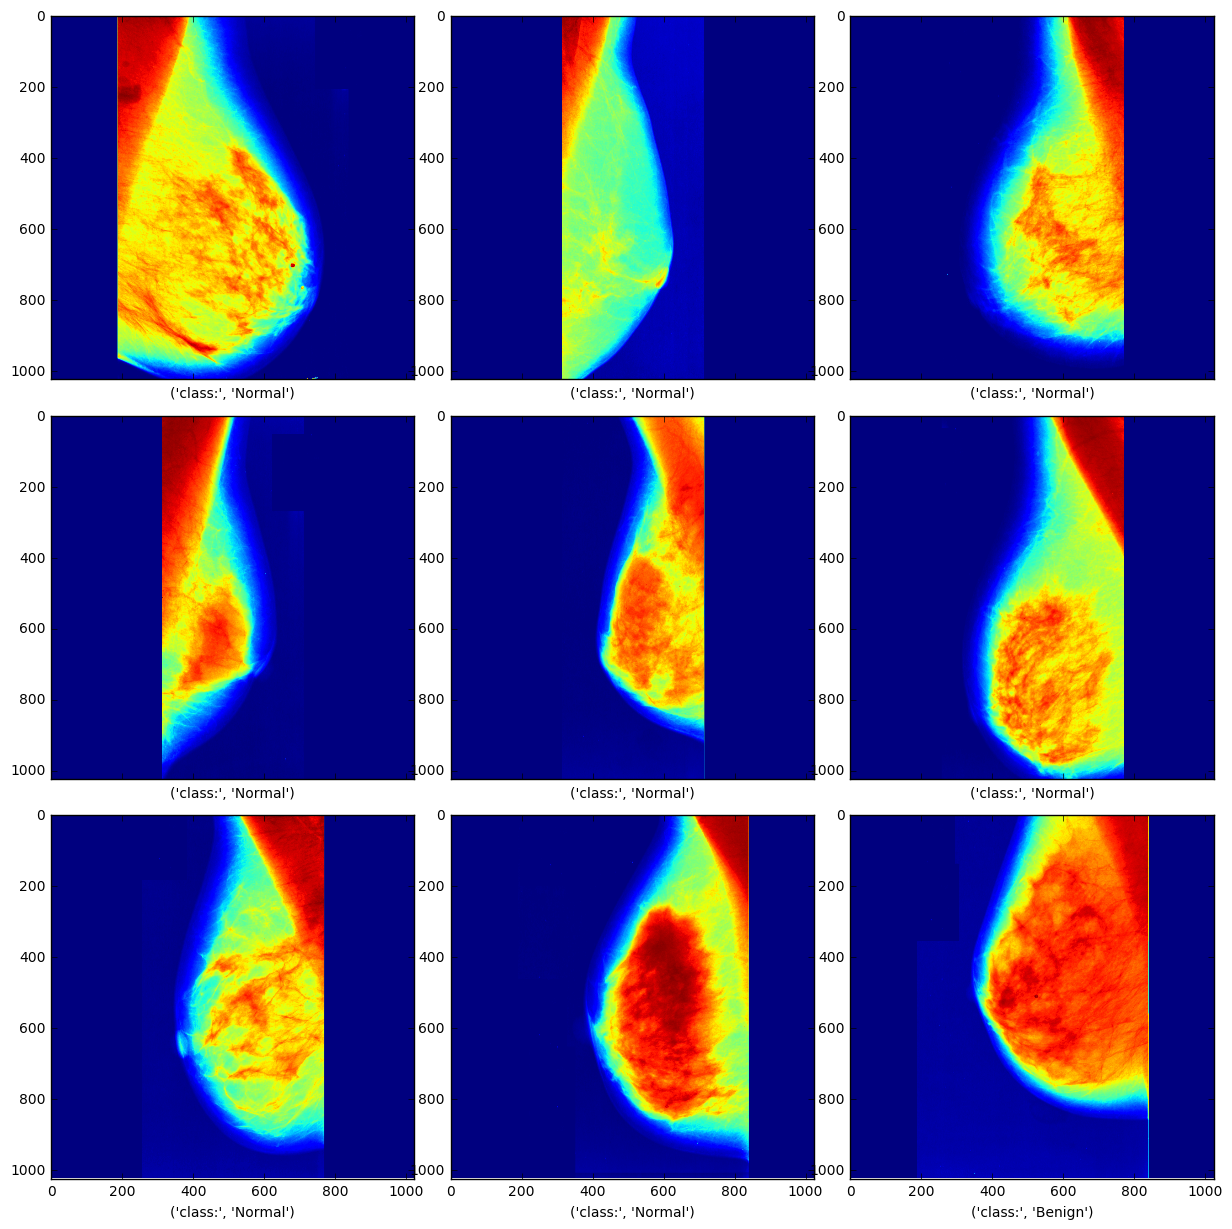

In [7]:
#read image pixel vals in
fileName = "./data/raw_data/UPNG/mdb"
# Display nine image which is selected randomly
random_indices = random.sample(range(len(train_mgrams)), min(len(train_mgrams), 9))
plot,axes = plt.subplots(3,3,figsize = (15,15), sharex=True)
ind=0
for i in random_indices:
    r = ind % 3 # Get subplot row
    c = ind // 3 # Get subplot column
    if i < 100:
        if i < 10:
            fname = fileName + "00" + str(i) + ".png"
        else:
            fname = fileName + "0" + str(i) + ".png"
    else:
        name = fileName + str(i) + ".png"

    im = Image.open(fname).load() 
    
    # Show true and predicted classes.
    if training_labels[i] ==0:
        label = "Normal"
    elif training_labels[i] ==1:
        label = 'Benign'
    else:
        label = 'Malignant'
    axes[r, c].set_xlabel(('class:',label))
    axes[r, c].imshow(mpimg.imread(fname))        
  
    ind+=1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [8]:
"""
Prepare kfold training data splits
"""

folds = 10
print("Performing ", folds, "-fold validation")

skf = StratifiedKFold(n_splits=NUM_FOLDS)
train_data    = []
test_data     = []
train_labels  = []
test_labels   = []
i = 0
delta = -1
for train_indices, test_indices in skf.split(training_labels, testing_labels):
    print("Train len: ", len(train_indices), "Test len: ", len(test_indices))
    
    train_batch = np.array([training_data[i] for i in train_indices])
    train_label = np.array([training_labels[i] for i in train_indices])
    test_batch = np.array([testing_data[i] for i in test_indices])
    test_label = np.array([testing_labels[i] for i in test_indices])
    
    train_data.append(np.ndarray(shape=(len(train_indices),IMAGE_X_DIM*IMAGE_Y_DIM), dtype=float32))
    train_labels.append(np.ndarray(shape=(len(train_indices),), dtype=uint8))
    test_data.append(np.ndarray(shape=(len(test_indices),IMAGE_X_DIM*IMAGE_Y_DIM), dtype=float32))
    test_labels.append(np.ndarray(shape=(len(test_indices),), dtype=uint8))
    if NUM_CLASSES == 3:
        delta = 0
        
    for j in range(len(train_indices)):
        train_labels[i][j] = train_label[j] + delta
        train_data[i][j] = train_batch[i][j]
    for j in range(len(test_indices)):
        test_labels[i][j] = test_label[j] + delta
        test_data[i][j]   = test_batch[i][j]
    i += 1

print(folds, "-fold validation prepared.\n")


Performing  10 -fold validation
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  88 Test len:  12
Train len:  90 Test len:  10
10 -fold validation prepared.



In [11]:
tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features['x'], [-1, IMAGE_X_DIM, IMAGE_Y_DIM, 1])
  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=FEATURES_LAYER_1,
      kernel_size=[KERNEL_LAYER_1, KERNEL_LAYER_1],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=FEATURES_LAYER_2,
      kernel_size=[KERNEL_LAYER_2, KERNEL_LAYER_2],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Convolutional Layer #3
  
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=FEATURES_LAYER_3,
      kernel_size=[KERNEL_LAYER_3, KERNEL_LAYER_3],
      padding="same",
      activation=tf.nn.relu)
  
  # Pooling Layer #3
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  pool2_flat = tf.reshape(pool3, [-1, 6* 6 * 128])

  # Dense Layer
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  logits = tf.layers.dense(inputs=dropout, units=NUM_CLASSES)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=NUM_CLASSES)
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [13]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")
# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)
#train_data[i], train_labels[i]
i = 0
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data[i]},
    y=train_labels[i],
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data[i]},
    y=test_labels[i],
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_save_checkpoints_steps': None, '_model_dir': '/tmp/mnist_convnet_model', '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334  0.33333334]
 [ 0.33333334  0.33333334